In [15]:
import os
import numpy as np
import pandas as pd

# to later draw the tree
import graphviz 
from sklearn import tree

# Machine learning algorithms
from sklearn.ensemble import AdaBoostRegressor #AdaBoost

# Cross-validation
'''
GridSearchCV = Perform an optimization of the parameters. 可以保证在指定的参数范围内找到精度最高的参数
                1. search for the best parameters for model; 
                2. automatically fit a new model on the training dataset w/ the parameters that 
                    can yield the best cross-validation performance.
cross_val_score = to implement cross-validation in scikit-learn.
PS: When an integer is passed to the cv parameter of cross_val_score():
        cv=int (same as cv=StratifiedKFold(n_splits=int)) is used if the estimator is a classifier 
        and y is either binary or multiclass; In all other cases, KFold is used.
        i.e. 写int=10会自动转换为KFold(n_splits=10),不会转换为StratifiedKFold(n_splits=10)。
'''
from sklearn.model_selection import GridSearchCV, cross_val_score

path = os.getcwd()#get current path
path_up1Dir = os.path.dirname(path)#go up one directory
dataset = pd.read_excel(path_up1Dir +'/y_MVPA/y_MVPA.xlsx')#to import the preprocessed dataset into a variable

# print(dataset)

In [16]:
X = pd.DataFrame(dataset.iloc[:,5:10])
y = dataset['aveTotalArea']
other = pd.DataFrame(dataset.iloc[:,:4])
# print(X, y, other)

In [17]:
# AdaBoost
'''
Why AdaBoostRegressor not AdaBoostClassifier?
    - first, there is a huge difference between classifiers and regressors. 
        Classifiers predict a set of specified labels. 
            e.g. Email Spam Detection, where to classify whether an email is either spam (1) or not spam(0) . 
        Regressors predict some value, which could be almost anything. 
            (predict real valued outputs which vary and dont require outputs predicted to be in a fixed set)
            e.g. Predicting the runs scored by a team in a cricket match.
    - in our case, we want to use data to predict MVPA_minutes.week from any of the four Total Area (cm²) average scores.
    - so, we are predicting a quantity instead of a label, which means we should use regressor.
'''

'''
The number of weak learners is controlled by the parameter n_estimators. 
The learning_rate parameter controls the contribution of the weak learners in the final combination. 
# n_estimators = The maximum number of estimators at which boosting is terminated.
# learning_rate = Weight applied to each classifier at each boosting iteration. 
                    A higher learning rate increases the contribution of each classifier. 
'''

# Set param_grid, aka the main parameters in RandomForestRegressor
param_grid_AdaBoostRegressor = {
    'n_estimators':np.arange(10,201,10), # 从10到200，每隔10取一个
    'learning_rate':np.arange(0.1,1.1,0.1) # 从0.1到1，每隔0.1取一个
}

rule = 'r2'

# GridSearchCV
abr = GridSearchCV(estimator=AdaBoostRegressor(), # algorithm - AdaBoost Regressor
                    param_grid=param_grid_AdaBoostRegressor, # specify the parameters to search over using a dict or list of dictionaries
                    cv=10, # 10-Fold
                    scoring=rule
                    )

# Build the model, aka training the dataset
abr.fit(X, y.values.ravel())

# Output the best parameter, cross-validation score, estimator, and the index of best estimator.
print("\n------------------ AdaBoostRegressor Model")
print("Best parameter: {}".format(abr.best_params_))
print("Best score in %s: {:.2f}".format(abr.best_score_) %rule)
print("Average score in 10-Fold: \n", abr.cv_results_['mean_test_score'])
print("Std score in 10-Fold: \n", abr.cv_results_['std_test_score'])
print("Best estimator: {}".format(abr.best_estimator_))
print("The Index of Best estimator: {}".format(abr.best_index_))


------------------ AdaBoostRegressor Model
Best parameter: {'learning_rate': 0.1, 'n_estimators': 30}
Best score in r2: 0.72
Average score in 10-Fold: 
 [0.71206984 0.71576439 0.7159801  0.7145329  0.70915091 0.70944976
 0.71038307 0.70288548 0.70322427 0.7018911  0.69916925 0.69826622
 0.69485371 0.69733062 0.69308182 0.69723294 0.69099943 0.69839098
 0.69792269 0.69714722 0.70434424 0.70995778 0.71283341 0.70214704
 0.70133353 0.70283108 0.69161817 0.69979918 0.69621004 0.69247682
 0.69315077 0.68879756 0.69925777 0.69409432 0.6913065  0.69394604
 0.69224624 0.6862291  0.69073187 0.69014636 0.69775151 0.69855563
 0.69463598 0.7019997  0.69179    0.68991223 0.6935703  0.6849175
 0.69277225 0.68525181 0.68594163 0.69102926 0.68538733 0.69112965
 0.69214723 0.69406016 0.69365476 0.6868615  0.68368344 0.68771304
 0.71294323 0.70166534 0.70522941 0.68782871 0.68987415 0.68819289
 0.69113067 0.69171907 0.68579936 0.68074606 0.6899449  0.68094134
 0.68999275 0.68370557 0.68726432 0.6815186

In [5]:
'''
机器学习不同于统计建模，有些定义不一样。sklearn这个包定义的比较奇怪而已。
https://zhuanlan.zhihu.com/p/369330147，score接近于1越好的是R2这个指标，其他的指标是接近于0越好。把负数去掉即可。
'''
# 10-Fold Cross-validation to check its accuracy again
score = cross_val_score(estimator=AdaBoostRegressor(learning_rate=0.1, n_estimators=10),
                        X=X, y=y.values.ravel(),
                        cv=10
                       )
print(score)

[-0.0339098  -0.79261576 -0.2294205  -0.28087003 -0.36918812 -0.20508435
 -0.09553414 -0.0125155   0.01815859 -0.05580265]


In [6]:
# Use the above optimal parameters to build new model, aka training the dataset
abr = AdaBoostRegressor(learning_rate=0.1, n_estimators=10).fit(X, y.values.ravel())

In [7]:
yhat = abr.predict(X)
print("Test set predictions:\n {}".format(yhat))

Test set predictions:
 [ 0.01621825 -0.07596243 -0.10328545 -0.11278097 -0.07596243 -0.07596243
 -0.11278097 -0.11278097 -0.07596243 -0.10328545 -0.11278097  0.11871911
 -0.11278097  0.17806328  0.17780786 -0.11278097 -0.07596243 -0.11278097
 -0.07596243  3.07091314 -0.11278097  0.11871911  0.01621825 -0.07596243
 -0.10328545  0.11871911 -0.10328545 -0.11278097 -0.11278097 -0.07596243
 -0.11278097 -0.07596243 -0.13728389  0.01621825 -0.11278097 -0.11278097
 -0.07596243 -0.11278097 -0.03593173 -0.11278097 -0.07596243  0.17780786
 -0.07596243 -0.11278097  0.11871911 -0.07596243 -0.10328545 -0.11278097
 -0.11278097  0.17780786  0.17780786 -0.11278097  0.17780786 -0.11278097
  0.17780786  0.17780786 -0.11278097 -0.07596243 -0.11278097 -0.10328545
 -0.11278097 -0.11278097 -0.11278097 -0.11278097 -0.11278097 -0.11278097
 -0.11278097 -0.10328545 -0.11278097  0.69059381 -0.11278097 -0.11278097
  0.01621825 -0.11278097 -0.07596243 -0.11278097 -0.07596243  0.11871911
 -0.11278097 -0.07596243 -0.

In [8]:
from sklearn.metrics import mean_squared_error as MSE
MSE(y_true=y, y_pred=yhat)

0.8601366798108312

In [9]:
#调用R2
from sklearn.metrics import r2_score
r2_score(yhat,y)

-11.675784549421879

In [10]:
r2 = abr.score(X,y)
r2

0.1398633201891688

In [11]:
r2_score(y_true = y, y_pred = yhat)

0.1398633201891688

In [13]:
cross_val_score(abr,X,y.values.ravel(),cv=10,scoring="r2").mean()

-0.40425801487128565

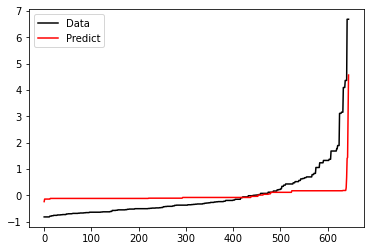

In [14]:
import matplotlib.pyplot as plt
y = dataset['MVPA']
sorted(y)
plt.plot(range(len(y)),sorted(y),c="black",label= "Data")
plt.plot(range(len(yhat)),sorted(yhat),c="red",label = "Predict")
plt.legend()
plt.show()

In [7]:
# Draw the AdaBoost
abr_tree = abr.estimators_[0] # Draw the first tree

# Export a decision tree w/ color in DOT format.
dot_data = tree.export_graphviz(decision_tree=abr_tree, # decision tree classifier
                               filled=True, # True: paint nodes to indicate majority class for classification, extremity of values for regression, or purity of node for multi-output
                               rounded=True, # True: draw node boxes with rounded corners and use Helvetica fonts instead of Times-Roman
                               special_characters=True # True: do not ignore special characters for PostScript compatibility
                               )

# Output the graph
graph = graphviz.Source(dot_data)
graph.render(filename='x_TotalArea_y_MVPA_AdaBoost', 
            directory=path_up1Dir +'/x_TotalArea_y_MVPA')

'/Users/zclalala/Documents/GitHub/project-posture/x_TotalArea_y_MVPA/x_TotalArea_y_MVPA_AdaBoost.pdf'